In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
from scipy.spatial.distance import pdist
import skgstat
import xdem
from typing import Callable

# date_string='Fall2021_v11'
date_string='Summer2022_v13'
pd.set_option('display.max_columns', 250)

In [2]:
Arctic_discharge_fluxes_with_area = gpd.read_file('Arctic_discharge_fluxes_with_area_epsg3995_'+date_string+'_V4.gpkg', driver="GPKG")#change file name based on distance


In [3]:
df_early_D = pd.read_pickle('df_all_reg_early_'+date_string+'.pkl')
df_late_D = pd.read_pickle('df_all_reg_late_'+date_string+'.pkl')

df_early_T = pd.read_pickle('df_all_reg_early_TC_'+date_string+'.pkl')
df_late_T = pd.read_pickle('df_all_reg_late_TC_'+date_string+'.pkl')

df_late_T['Tg_errH_corr'].fillna(0,inplace=True)#fix a problem where iceland is nan in this column (no area gained)

In [4]:
regions = df_early_T['region'].unique()
# regions = regions[regions!='Greenland'] #uncomment to exclude periphery Greenland from the total numbers
for period in ['early','late']:
    list_df_reg = []
    list_df_uncertain = []
    for region in regions:
        print(region)
        if period == 'early':
            df_T = df_early_T[df_early_T['region']==region]
            df_D = df_early_D[df_early_D['region']==region]
            time='2000_to_2010'
            time2='2000_2010'
            time3 = 'early_to_middle_years_elapsed'
        if period == 'late':
            df_T = df_late_T[df_late_T['region']==region]
            df_D = df_late_D[df_late_D['region']==region]
            time='2010_to_2020'
            time2='2010_2020'
            time3 = 'middle_to_late_years_elapsed'
            
        df_FA = Arctic_discharge_fluxes_with_area[Arctic_discharge_fluxes_with_area['region']==region]
        
        Tg_errA = np.sum(df_FA['perimeter_error_gained_'+period]/df_FA[time3]*df_FA['thickness_for_area_gained_'+period]*0.9/1000)
        Tl_errA = np.sum(df_FA['perimeter_error_lost_'+period]/df_FA[time3]*df_FA['thickness_for_area_lost_'+period]*0.9/1000)

        sig_ID_raw_reg = df_D['V_tot_err_corr']
        sig_TC_raw_reg = np.sqrt(df_T['Tg_errH_corr']**2 + df_T['Tl_errH_corr']**2 + Tg_errA**2 + Tl_errA**2)
        sig_ID_clim_reg = np.sqrt(sum(df_FA['melt_correct_gt_'+period+'_err_discharge']**2))
        sig_TC_clim_reg = np.sqrt(sum(df_FA['melt_correct_gt_'+period+'_err_terminus_change']**2))

        sig_FA_reg = np.sqrt(sig_ID_raw_reg**2 + sig_ID_clim_reg**2 + sig_TC_raw_reg**2 + sig_TC_clim_reg**2) *2 #convert to 2 sigma error
        sig_FA_reg=sig_FA_reg[0]
#         print('--',sig_FA_reg)
        
        sig_D = np.sqrt(sig_ID_raw_reg**2 + sig_ID_clim_reg**2) *2
        sig_TC = np.sqrt(+ sig_TC_raw_reg**2 + sig_TC_clim_reg**2) *2
        
        df_reg = pd.DataFrame()
        df_reg = df_reg.assign(region=[region],FA=[sum(df_FA['Frontal_ablation_'+time+'_gt_per_yr_mean'])],FA_err=[sig_FA_reg],
                               Discharge=[sum(df_FA[time2+'_mean_flux_gt'])],D_err=[sig_D[0]],
                               Terminus_change=[sum(df_FA['terminus_gt_change_per_year_'+period])],TC_err=[sig_TC[0]]
                              )
        list_df_reg.append(df_reg)
        
        df_uncertain = pd.DataFrame()
        df_uncertain = df_uncertain.assign(region=[region],
                                           D_raw=[sig_ID_raw_reg[0]**2],
                                           TC_raw=[sig_TC_raw_reg[0]**2],
                                           D_clim=[sig_ID_clim_reg**2],
                                           TC_clim=[sig_TC_clim_reg**2]
                                          )
        list_df_uncertain.append(df_uncertain)
        
    if period=='early':
        df_reg_early = pd.concat(list_df_reg)
        df_uncertain_early = pd.concat(list_df_uncertain)
    if period=='late':
        df_reg_late = pd.concat(list_df_reg)
        df_uncertain_late = pd.concat(list_df_uncertain)

Alaska
BBI
FJL
Greenland
Iceland
NZ
QEI
SZ
Svalbard and Jan Mayen
Alaska
BBI
FJL
Greenland
Iceland
NZ
QEI
SZ
Svalbard and Jan Mayen


In [5]:
df_uncertain_early

,region,D_raw,TC_raw,D_clim,TC_clim
0,Alaska,0.019243,0.006858,0.012096,0.000409
0,BBI,0.000287,0.001110,0.000017,0.000002
0,FJL,5.603590,0.772033,0.000418,0.000015
0,Greenland,0.147894,0.462761,0.002228,0.000131
0,Iceland,0.000846,0.000131,0.001534,0.000004
0,NZ,0.176438,0.081965,0.000313,0.000013
0,QEI,0.101518,0.206036,0.002656,0.000069
0,SZ,0.278130,0.046234,0.002624,0.000013
0,Svalbard and Jan Mayen,0.973204,0.783041,0.005015,0.000064


In [6]:
#global total
df_global = pd.DataFrame()
df_global['region'] = 'total'
df_global = df_global.assign(FA_early=[sum(df_reg_early['FA'])],
                             FA_early_err=[np.sqrt(sum(df_reg_early['FA_err']**2))],
                             FA_late=[sum(df_reg_late['FA'])],
                             FA_late_err=[np.sqrt(sum(df_reg_late['FA_err']**2))],
                             
                             D_early=[sum(df_reg_early['Discharge'])],
                             D_early_err=[np.sqrt(sum(df_reg_early['D_err']**2))],
                             D_late=[sum(df_reg_late['Discharge'])],
                             D_late_err=[np.sqrt(sum(df_reg_late['D_err']**2))],
                             
                             TC_early=[sum(df_reg_early['Terminus_change'])],
                             TC_early_err=[np.sqrt(sum(df_reg_early['TC_err']**2))],
                             TC_late=[sum(df_reg_late['Terminus_change'])],
                             TC_late_err=[np.sqrt(sum(df_reg_late['TC_err']**2))],
                             
                             gate_length_km = [sum(Arctic_discharge_fluxes_with_area['gate_length_km'])],
                             num_glaciers = [Arctic_discharge_fluxes_with_area['RGIId'][Arctic_discharge_fluxes_with_area['region']!='Greenland'].count()]
                             )
df_global['region'] = 'total'
df_global

,region,FA_early,FA_early_err,FA_late,FA_late_err,D_early,D_early_err,D_late,D_late_err,TC_early,TC_early_err,TC_late,TC_late_err,gate_length_km,num_glaciers
0,total,44.468614,6.225412,51.980958,4.620898,35.398313,5.414075,40.415414,2.61204,-9.070301,3.073036,-11.565544,3.811816,3802.047382,959


In [7]:
print(str(round((df_global['FA_early']+df_global['FA_late'])/2,2)[0]),' ± ',str(round((df_global['FA_early_err']+df_global['FA_late_err'])/2,2)[0]))

48.22  ±  5.42


In [8]:
#build table 1
df_gate = Arctic_discharge_fluxes_with_area.groupby('region').sum()[['gate_length_km']].round().reset_index()
df_num = Arctic_discharge_fluxes_with_area.groupby('region').count()[['RGIId']].reset_index()
df_num.rename(columns={'RGIId':'num_glaciers'},inplace=True)

df_final = df_reg_early.merge(df_gate,left_on='region',right_on='region').merge(df_num,left_on='region',right_on='region')
df_final.rename(columns={'FA':'FA_early','FA_err':'FA_early_err',
                        'Discharge':'D_early','D_err':'D_early_err',
                        'Terminus_change':'TC_early','TC_err':'TC_early_err'},inplace=True)

df_final = df_final.merge(df_reg_late)
df_final.rename(columns={'FA':'FA_late','FA_err':'FA_late_err',
                        'Discharge':'D_late','D_err':'D_late_err',
                        'Terminus_change':'TC_late','TC_err':'TC_late_err'},inplace=True)

df_final = df_final[['region', 'FA_early', 'FA_early_err','FA_late','FA_late_err',
'D_early', 'D_early_err','D_late', 'D_late_err',
'TC_early', 'TC_early_err','TC_late', 'TC_late_err','gate_length_km', 'num_glaciers',]]

# df_final = df_final.append(df_global).round(2)
df_final['gate_length_km']=df_final['gate_length_km'].astype('int')
df_final.reset_index(drop=True,inplace=True)
df_final.to_pickle('FA_regional_results'+date_string+'.pkl')

In [16]:
df_final

,region,FA_early,FA_early_err,FA_late,FA_late_err,D_early,D_early_err,D_late,D_late_err,TC_early,TC_early_err,TC_late,TC_late_err,gate_length_km,num_glaciers
0,Alaska,11.590140,0.392966,10.680662,0.332951,11.494634,0.354058,9.791141,0.180708,-0.095507,0.170487,-0.889521,0.279645,80,42
1,BBI,0.088878,0.075245,0.087500,0.075406,0.043441,0.034889,0.028674,0.024221,-0.045437,0.066668,-0.058826,0.071411,40,86
2,FJL,10.458657,5.050171,7.438550,3.293486,8.782888,4.734557,4.680333,2.212169,-1.675769,1.757326,-2.758217,2.439950,1377,328
3,Greenland,4.305632,1.565904,3.176132,1.090514,2.251698,0.774911,1.881270,0.430582,-2.053934,1.360723,-1.294862,1.001908,697,537
4,Iceland,0.101617,0.100303,0.026796,0.088645,0.098955,0.097580,0.000601,0.073061,-0.002662,0.023212,-0.026196,0.050200,5,1
5,NZ,2.665301,1.017308,4.148618,0.933137,2.016913,0.840834,3.144788,0.371454,-0.648388,0.572637,-1.003829,0.856018,182,39
6,QEI,4.136396,1.114052,4.275447,1.181872,2.681971,0.645519,2.244291,0.328192,-1.454426,0.907974,-2.031156,1.135391,481,252
7,SZ,3.504501,1.143682,5.330368,0.875906,3.145425,1.059725,4.229354,0.594152,-0.359076,0.430105,-1.101014,0.643579,283,45
8,Svalbard and Jan Mayen,7.617491,2.654298,16.816885,2.481380,4.882389,1.978100,14.414962,1.051844,-2.735102,1.769864,-2.401923,2.247415,657,166


In [14]:
df_show = pd.DataFrame()
for i in range(0,len(df_final)):
    df_show.loc[i,'region']=df_final['region'][i]
    df_show.loc[i,'FA_early']=str(round(df_final['FA_early'][i],2))+' ± '+str(round(df_final['FA_early_err'][i],2))
    df_show.loc[i,'FA_late']=str(round(df_final['FA_late'][i],2))+' ± '+str(round(df_final['FA_late_err'][i],2))
    
    df_show.loc[i,'D_early']=str(round(df_final['D_early'][i],2))+' ± '+str(round(df_final['D_early_err'][i],2))
    df_show.loc[i,'D_late']=str(round(df_final['D_late'][i],2))+' ± '+str(round(df_final['D_late_err'][i],2))
    
    df_show.loc[i,'TC_early']=str(round(df_final['TC_early'][i],2))+' ± '+str(round(df_final['TC_early_err'][i],2))
    df_show.loc[i,'TC_late']=str(round(df_final['TC_late'][i],2))+' ± '+str(round(df_final['TC_late_err'][i],2))
    
    df_show.loc[:,'gate_length_km']=df_final['gate_length_km']
    df_show.loc[:,'num_glaciers']=df_final['num_glaciers']
df_show

,region,FA_early,FA_late,D_early,D_late,TC_early,TC_late,gate_length_km,num_glaciers
0,Alaska,11.59 ± 0.39,10.68 ± 0.33,11.49 ± 0.35,9.79 ± 0.18,-0.1 ± 0.17,-0.89 ± 0.28,80,42
1,BBI,0.09 ± 0.08,0.09 ± 0.08,0.04 ± 0.03,0.03 ± 0.02,-0.05 ± 0.07,-0.06 ± 0.07,40,86
2,FJL,10.46 ± 5.05,7.44 ± 3.29,8.78 ± 4.73,4.68 ± 2.21,-1.68 ± 1.76,-2.76 ± 2.44,1377,328
3,Greenland,4.31 ± 1.57,3.18 ± 1.09,2.25 ± 0.77,1.88 ± 0.43,-2.05 ± 1.36,-1.29 ± 1.0,697,537
4,Iceland,0.1 ± 0.1,0.03 ± 0.09,0.1 ± 0.1,0.0 ± 0.07,-0.0 ± 0.02,-0.03 ± 0.05,5,1
5,NZ,2.67 ± 1.02,4.15 ± 0.93,2.02 ± 0.84,3.14 ± 0.37,-0.65 ± 0.57,-1.0 ± 0.86,182,39
6,QEI,4.14 ± 1.11,4.28 ± 1.18,2.68 ± 0.65,2.24 ± 0.33,-1.45 ± 0.91,-2.03 ± 1.14,481,252
7,SZ,3.5 ± 1.14,5.33 ± 0.88,3.15 ± 1.06,4.23 ± 0.59,-0.36 ± 0.43,-1.1 ± 0.64,283,45
8,Svalbard and Jan Mayen,7.62 ± 2.65,16.82 ± 2.48,4.88 ± 1.98,14.41 ± 1.05,-2.74 ± 1.77,-2.4 ± 2.25,657,166


In [50]:
df_show = pd.DataFrame()
for i in range(0,len(df_final)):
    df_show.loc[i,'region']=df_final['region'][i]
    df_show.loc[i,'FA_total']=str(round((df_final['FA_early'][i]+df_final['FA_late'][i])/2,2))+' ± '+str(round((df_final['FA_early_err'][i]+df_final['FA_late_err'][i])/2,2))

df_show

,region,FA_total
0,Alaska,11.14 ± 0.36
1,BBI,0.09 ± 0.08
2,FJL,8.95 ± 4.17
3,Greenland,3.74 ± 1.33
4,Iceland,0.06 ± 0.09
5,NZ,3.41 ± 0.98
6,QEI,4.21 ± 1.15
7,SZ,4.42 ± 1.01
8,Svalbard and Jan Mayen,12.22 ± 2.57


In [12]:
#sea level rise of discharge:
print((df_global['D_early'][0]+df_global['D_late'][0])/2*20/360)
print((df_global['D_early_err'][0]+df_global['D_late_err'][0])/2*20/360)

2.1059368556443
0.22294763124865832


In [19]:
df_uncertain_early

,region,D_raw,TC_raw,D_clim,TC_clim
0,Alaska,0.024324,0.006858,0.014131,0.000409
0,BBI,0.000253,0.001110,0.000018,0.000002
0,FJL,11.128534,0.772036,0.000389,0.000015
0,Greenland,0.176968,0.462840,0.002108,0.000131
0,Iceland,0.001920,0.000131,0.001702,0.000004
0,NZ,0.259470,0.081965,0.000302,0.000013
0,QEI,0.138093,0.206036,0.002484,0.000069
0,SZ,0.497362,0.046234,0.002447,0.000013
0,Svalbard and Jan Mayen,2.040199,0.783037,0.004710,0.000064


<BarContainer object of 9 artists>

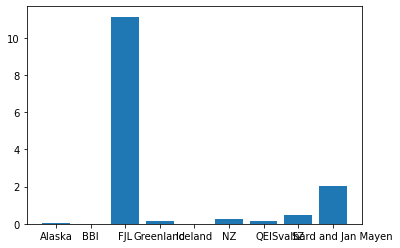

In [20]:
plt.bar(df_uncertain_early['region'],df_uncertain_early['D_raw'])

<AxesSubplot:xlabel='region'>

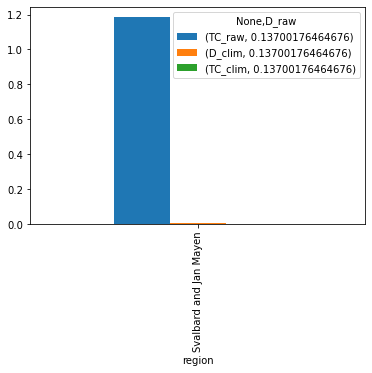

In [175]:
df_uncertain.pivot('region','D_raw').plot(kind='bar')

<AxesSubplot:title={'center':'2000-2010'}, xlabel='region', ylabel='squared unceratinties (Gt2 a-2)'>

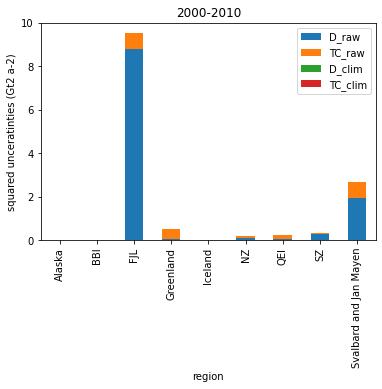

In [196]:
df_uncertain_early.plot.bar(x='region',stacked=True,ylim=(0,10),ylabel='squared unceratinties (Gt2 a-2)', title='2000-2010')
# plt.set_xlim(0,10)

<AxesSubplot:title={'center':'2010-2020'}, xlabel='region', ylabel='squared unceratinties (Gt2 a-2)'>

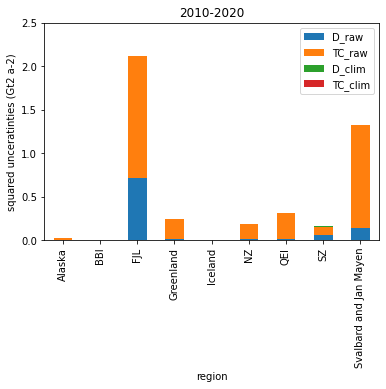

In [197]:
df_uncertain_late.plot.bar(x='region',stacked=True,ylim=(0,2.5),ylabel='squared unceratinties (Gt2 a-2)', title='2010-2020')

In [45]:
df_all_early = pd.read_pickle('df_all_early_'+date_string+'.pkl').sort_values('rgiid').reset_index(drop=True)
df_all_late = pd.read_pickle('df_all_late_'+date_string+'.pkl').sort_values('rgiid').reset_index(drop=True)

Arctic_discharge_fluxes_with_area = Arctic_discharge_fluxes_with_area.sort_values('RGIId')

# #matusevich changes
# subset_index = (Arctic_discharge_fluxes_with_area['RGIId']=='RGI60-09.00515_2')|(Arctic_discharge_fluxes_with_area['RGIId']=='RGI60-09.00498_3')|(Arctic_discharge_fluxes_with_area['RGIId']=='RGI60-09.00498_2')|(Arctic_discharge_fluxes_with_area['RGIId']=='RGI60-09.00498')|(Arctic_discharge_fluxes_with_area['RGIId']=='RGI60-09.00515')|(Arctic_discharge_fluxes_with_area['RGIId']=='RGI60-09.00968_2')|(Arctic_discharge_fluxes_with_area['RGIId']=='RGI60-09.00968')|(Arctic_discharge_fluxes_with_area['RGIId']=='RGI60-09.00967') #retained by terminus

#get a subset of df_all_early and df_all_late here
# subset_index = Arctic_discharge_fluxes_with_area['terminus_gt_change_per_year_late']>0 #retained by terminus
# subset_index = Arctic_discharge_fluxes_with_area['terminus_gt_change_per_year_late']<0 #lost by terminus

#Just look at frontal ablation of advancing glaciers
# subset_index = (Arctic_discharge_fluxes_with_area['net_area_change_per_year_early']>0)&\
#     (Arctic_discharge_fluxes_with_area['net_area_change_per_year_early']>Arctic_discharge_fluxes_with_area['net_area_change_per_year_early_error'])   
# subset_index = (Arctic_discharge_fluxes_with_area['net_area_change_per_year_late']>0)&\
#     (Arctic_discharge_fluxes_with_area['net_area_change_per_year_late']>Arctic_discharge_fluxes_with_area['net_area_change_per_year_late_error'])

# subset_index = Arctic_discharge_fluxes_with_area['FA_not_calculated_in_normal_way_early'] == 1
subset_index = Arctic_discharge_fluxes_with_area['FA_not_calculated_in_normal_way_late'] == 1

df_all_early=df_all_early[subset_index]
df_all_late=df_all_late[subset_index]

df_all_early['region']='same'
df_all_late['region']='same'

/Users/willkochtitzky/opt/miniconda3/envs/gis/lib/python3.7/site-packages/ipykernel_launcher.py:22: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/willkochtitzky/opt/miniconda3/envs/gis/lib/python3.7/site-packages/ipykernel_launcher.py:23: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


In [46]:
#ERROR ANALYSIS from ROMAIN - but only for subset
for period in ['early','late']:
    if period == 'early':
        period_date = '2000_2010'
    else:
        period_date = '2010_2018'

    print('Running for period: '+period)

    # Parameters estimated for ghe variograms (nb_model x (correlation range, partial sill)) for velocity and ice thickness:
    # ranges in meters, partial sills are in percentage of the variance
    params_velocity =((691 ,63), (18000, 26),
                      (1040000, 11))
    params_icethickness = ((2100, 28), (47000, 50),
                           (1354000, 22))

    def sum_vgm(h, params, error1, error2):
        """Sum of variograms models"""
        v = 0
        for k in range(len(params)):
            v += skgstat.models.spherical(h, params[k][0], params[k][1] * error1 * error2)

        return v

    def product_vgms(h, mean_vn_err, mean_Hn_err, mean_d, mean_vn, mean_Hn):
        """Quadratic product of independent velocity and ice thickness variograms"""

        v = (sum_vgm(h, params_velocity, mean_Hn_err, mean_Hn_err) * mean_d ** 2 * mean_vn ** 2 + \
             sum_vgm(h, params_icethickness, mean_vn_err, mean_vn_err) * mean_d ** 2 * mean_Hn ** 2) /\
            ((mean_Hn_err**2 * mean_vn**2 * mean_d**2 + mean_vn_err**2 * mean_Hn**2 * mean_d**2) * 100)
        return v

    # Function to integrate the variogram from a spatial support to another: a double sum of covariances
    def double_sum_covar(coords: np.ndarray, areas: np.ndarray, errors: np.ndarray,
                         vgm_func: Callable):
        """
        Double sum of covariance for euclidean coordinates
        :param coords: Spatial support (typically, pixel) coordinates
        :param areas:  Area of supports
        :param errors: Standard errors of supports
        :param vgm_func: Variogram function
        :return:
        """

        n = len(coords)
        pds = pdist(coords)
        var = 0
        for i in range(n):
            for j in range(n):

                # For index calculation of the pairwise distance, see https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.pdist.html
                if i == j:
                    d = 0
                elif i < j:
                    ind = n * i + j - ((i + 2) * (i + 1)) // 2
                    d = pds[ind]
                else:
                    ind = n * j + i - ((j + 2) * (j + 1)) // 2
                    d = pds[ind]

                var += errors[i] * errors[j] * (1 - vgm_func(d)) * areas[i] * areas[j]

        total_area = sum(areas)
        se_dsc = np.sqrt(var / total_area ** 2)

        return se_dsc

    # 2/ Propagation glacier -> region
    list_df_reg = []
    for region in ['same']:

        print('Working on region: '+region)

        # Isolate region of interest
        if period=='early':
            df_reg = df_all_early[df_all_early.region == region]
        if period=='late':
            df_reg = df_all_late[df_all_late.region == region]
        # Sum volume discharges
        V_tot_reg = np.sum(df_reg.V_tot.values)

        # Uncertainty on the sum, considering everything independent
        V_tot_err_uncorr_reg = np.sqrt(np.nansum(df_reg.V_tot_err_uncorr.values ** 2))

        # Uncertainty on the sum, considering everything correlated
        V_tot_err_fullycorr_reg = np.nansum(df_reg.V_tot_err_fullycorr)

        # Get the regional weighted mean of velocities, thicknesses, flux gate width, and related uncertainties
        mean_vn_reg = np.nansum(df_reg.mean_vn.values * df_reg.nb_flux_gates.values)/np.nansum(df_reg.nb_flux_gates.values)
        mean_Hn_reg = np.nansum(df_reg.mean_Hn.values * df_reg.nb_flux_gates.values)/np.nansum(df_reg.nb_flux_gates.values)
        mean_d_reg = np.nansum(df_reg.mean_d.values * df_reg.nb_flux_gates.values)/np.nansum(df_reg.nb_flux_gates.values)
        mean_vn_err_reg = np.nansum(df_reg.mean_vn_err.values * df_reg.nb_flux_gates.values)/np.nansum(df_reg.nb_flux_gates.values)
        mean_Hn_err_reg = np.nansum(df_reg.mean_Hn.values * df_reg.nb_flux_gates.values)/np.nansum(df_reg.nb_flux_gates.values)
        mean_d_err_reg = np.nansum(df_reg.mean_d_err.values * df_reg.nb_flux_gates.values)/np.nansum(df_reg.nb_flux_gates.values)

        # Define the average ice discharge correlation function in the region accordingly
        def vgm_func_gla(h):
            v = product_vgms(h, mean_vn_err_reg, mean_Hn_err_reg, mean_d_reg, mean_vn_reg, mean_Hn_reg)
            return v

        # Uncertainty on the sum, accounting for spatial correlations in velocities and ice thickness
        coords = np.array((df_reg['mean_easting'].values, df_reg['mean_northing'].values)).T
        V_tot_err_corr_reg = double_sum_covar(coords=coords, areas=np.ones(len(coords)), errors=df_reg.V_tot_err_corr.values,
                                          vgm_func=vgm_func_gla) * len(coords)

        # Store results in a dataframe
        df_res_reg = pd.DataFrame()
        df_res_reg = df_res_reg.assign(region=[region], V_tot=[V_tot_reg],
                               V_tot_err_uncorr=[V_tot_err_uncorr_reg], V_tot_err_corr=[V_tot_err_corr_reg],
                               V_tot_err_fullycorr=[V_tot_err_fullycorr_reg],
                               nb_flux_gates=[np.sum(df_reg.nb_flux_gates.values)],
                               mean_vn=[mean_vn_reg], mean_Hn=[mean_Hn_reg], mean_d=[mean_d_reg],
                               mean_vn_err=[mean_vn_err_reg], mean_Hn_err=[mean_Hn_err_reg], mean_d_err=[mean_d_err_reg])
        list_df_reg.append(df_res_reg)

    df_all_reg = pd.concat(list_df_reg)
    if period=='early':
        df_all_reg.to_pickle('df_all_reg_early_subset_'+date_string+'.pkl')
    if period=='late':
        df_all_reg.to_pickle('df_all_reg_late_subset_'+date_string+'.pkl')

    # 3/ Propagation region -> global

    print('Working on global total')

    # Sum volume discharges
    V_tot_global = np.sum(df_all_reg.V_tot.values)

    # Uncertainty on the sum, considering everything independent
    V_tot_err_uncorr_global = np.sqrt(np.nansum(df_all_reg.V_tot_err_uncorr.values ** 2))

    # Uncertainty on the sum, accounting for spatial correlations in velocities and ice thickness
    # For the global step, no correlations after >1000 km, so we can simply sum quadratically
    V_tot_err_corr_global = np.sqrt(np.nansum(df_all_reg.V_tot_err_corr.values ** 2))

    # Uncertainty on the sum, considering everything correlated
    V_tot_err_fullycorr_global = np.nansum(df_all_reg.V_tot_err_fullycorr)

    # Get the global weighted mean of velocities, thicknesses, flux gate width, and related uncertainties
    mean_vn_global = np.nansum(df_all_reg.mean_vn.values * df_all_reg.nb_flux_gates.values) / np.nansum(df_all_reg.nb_flux_gates.values)
    mean_Hn_global = np.nansum(df_all_reg.mean_Hn.values * df_all_reg.nb_flux_gates.values) / np.nansum(df_all_reg.nb_flux_gates.values)
    mean_d_global = np.nansum(df_all_reg.mean_d.values * df_all_reg.nb_flux_gates.values) / np.nansum(df_all_reg.nb_flux_gates.values)
    mean_vn_err_global = np.nansum(df_all_reg.mean_vn_err.values * df_all_reg.nb_flux_gates.values) / np.nansum(
        df_all_reg.nb_flux_gates.values)
    mean_Hn_err_global = np.nansum(df_all_reg.mean_Hn.values * df_all_reg.nb_flux_gates.values) / np.nansum(
        df_all_reg.nb_flux_gates.values)
    mean_d_err_global = np.nansum(df_all_reg.mean_d_err.values * df_all_reg.nb_flux_gates.values) / np.nansum(
        df_all_reg.nb_flux_gates.values)

    df_global = pd.DataFrame()
    df_global = df_global.assign(region=['Global total'], V_tot=[V_tot_global],
                               V_tot_err_uncorr=[V_tot_err_uncorr_global], V_tot_err_corr=[V_tot_err_corr_global],
                               V_tot_err_fullycorr=[V_tot_err_fullycorr_global],
                               nb_flux_gates=[np.sum(df_all_reg.nb_flux_gates.values)],
                               mean_vn=[mean_vn_global], mean_Hn=[mean_Hn_global], mean_d=[mean_d_global],
                               mean_vn_err=[mean_vn_err_global], mean_Hn_err=[mean_Hn_err_global], mean_d_err=[mean_d_err_global])

    if period=='early':
        df_reg_global_early = pd.concat([df_all_reg, df_global])
    if period=='late':
        df_reg_global_late = pd.concat([df_all_reg, df_global])
    #df_reg_global.to_csv('/home/atom/ongoing/work_frontal_ablation/df_region_global_final_'+period+'.csv')

Running for period: early
Working on region: same
Working on global total
Running for period: late
Working on region: same
Working on global total


In [47]:
#define subset from Arctic_discharge_fluxes_with_area
df_Subset = Arctic_discharge_fluxes_with_area[subset_index]
df_Subset['region']='same'

#calculate the spatial correlation of the terminus change volume error from Romain
# Define the NMAD as a robust measure of dispersion
def nmad(data: np.ndarray, nfact: float = 1.4826) -> float:
    """
    Calculate the normalized median absolute deviation (NMAD) of an array.

    :param data: input data
    :param nfact: normalization factor for the data; default is 1.4826

    :returns nmad: (normalized) median absolute deviation of data.
    """
    data_arr = np.asarray(data)
    return nfact * np.nanmedian(np.abs(data_arr - np.nanmedian(data_arr)))

for period in ['early','late','total']:
    print('Running for period: '+period)
    # 1/ Derive uncertainty for pixel -> glacier based on the area of averaging (lost or gained)
    # Get variables of interest: ice thickness

    if period == 'early':
        dt = df_Subset['early_to_middle_years_elapsed'].values
    else:
        dt = df_Subset['middle_to_late_years_elapsed'].values

    # Lost
    meanHl = df_Subset['thickness_for_area_lost_' + period].values
    meanHl_err_fullycorr = df_Subset['thickness_for_area_lost_' + period + '_err'].values
    dSldt = df_Subset['area_km2_lost_' + period].values / dt
    
    # Remove aberrantly large uncertainty values for ice thickness uncertainty
    meanHl_err_fullycorr[np.abs(meanHl_err_fullycorr - np.nanmedian(meanHl_err_fullycorr)) > 5 * nmad(meanHl_err_fullycorr)] = np.nan
    # Replace no data that might exist in the uncertainty from the average uncertainty
    meanHl_err_fullycorr[~np.isfinite(meanHl_err_fullycorr)] = np.nanmean(meanHl_err_fullycorr)

    # Gained
    meanHg = df_Subset['thickness_for_area_gained_' + period].values
    meanHg_err_fullycorr = df_Subset['thickness_for_area_gained_' + period + '_err'].values
    dSgdt = df_Subset['area_km2_gained_' + period].values / dt

    # Remove aberrantly large uncertainty values for ice thickness uncertainty
    meanHg_err_fullycorr[np.abs(meanHg_err_fullycorr - np.nanmedian(meanHg_err_fullycorr)) > 5 * nmad(meanHg_err_fullycorr)] = np.nan
    # Replace no data that might exist in the uncertainty from the average uncertainty
    meanHg_err_fullycorr[~np.isfinite(meanHg_err_fullycorr)] = np.nanmean(meanHg_err_fullycorr)

    # Parameters estimated for the ice thickness variogram (correlation range, partial sill):
    # range in meters, partial sill is in percentage of the variance
    params_icethickness = ((2100, 28), (47000, 50),
                           (1354000, 22))
    
    # Looping for every glacier
    unique_rgiid = list(np.unique(df_Subset['RGIId'].values))

    list_Hl_err_corr, list_Hg_err_corr = ([] for i in range(2))
    for rgiid in unique_rgiid:

        # Select only a given RGIId = glacier
        index_glacier = (df_Subset['RGIId'] == rgiid)

#         print('Working on glacier: '+rgiid + ' with '+ str(np.count_nonzero(index_glacier))+ ' flux gates...')

        # Variograms parameters formatted for xdem
        list_vgm=[(params_icethickness[0][0], 'Sph', params_icethickness[0][1]),
                  (params_icethickness[1][0], 'Sph', params_icethickness[1][1]),
                  (params_icethickness[2][0], 'Sph', params_icethickness[2][1])]

        # a/ Terminus lost
        # Number of effective samples in the area from the variogram
        dSl = dSldt[index_glacier] * dt[index_glacier]
        neff_l = xdem.spatialstats.neff_circ(area=dSl*10**6, list_vgm=list_vgm)

        # Uncertainty value for the average ice thickness of the glacier considering spatial correlation
        if dSl != 0:
            meanHl_err_corr = meanHl_err_fullycorr[index_glacier][0] / np.sqrt(neff_l)[0]
        else:
            meanHl_err_corr = 0

#         print('For terminus lost:')
#         print('Replacing fully correlated averaged ice thickness error {:.1f} m into spatially correlated {:.1f} m'.format(meanHl_err_fullycorr[index_glacier][0], meanHl_err_corr))
        list_Hl_err_corr.append(meanHl_err_corr)

        # b/ Terminus gained
        # Number of effective samples in the area from the variogram
        dSg = dSgdt[index_glacier] * dt[index_glacier]
        neff_g = xdem.spatialstats.neff_circ(area=dSg*10**6, list_vgm=list_vgm)

        # Uncertainty value for the average ice thickness of the glacier considering spatial correlation
        if dSg != 0:
            meanHg_err_corr = meanHg_err_fullycorr[index_glacier][0] / np.sqrt(neff_g)[0]
        else:
            meanHg_err_corr = 0

#         print('For terminus gained:')
#         print('Replacing fully correlated averaged ice thickness error {:.1f} m into spatially correlated {:.1f} m'.format(meanHg_err_fullycorr[index_glacier][0],meanHg_err_corr))
        list_Hg_err_corr.append(meanHg_err_corr)

    # Load under the names previously used
    meanHl_err = df_Subset['thickness_for_area_lost_' + period + '_err'].values
    meanHg_err = df_Subset['thickness_for_area_gained_' + period + '_err'].values

    # 2/ Propagation glacier -> region

    list_regions = list(np.unique(df_Subset.region.values))

    list_df_reg = []
    for region in list_regions:

        print('Working on region: '+region)

        # Isolate region of interest
        ind_reg = df_Subset.region.values == region

        # Terminus ice lost
        Tl_reg = np.sum(meanHl[ind_reg] * dSldt[ind_reg]) * 0.9 / 1000
        mean_meanHl_reg = np.nanmean(meanHl[ind_reg])
        mean_dSldt_reg = np.nanmean(dSldt[ind_reg])
        mean_meanHl_err_reg = np.nanmean(meanHl_err[ind_reg])

        # Terminus ice gained
        Tg_reg = np.sum(meanHg_err[ind_reg] * dSgdt[ind_reg]) * 0.9 / 1000
        mean_meanHg_reg = np.nanmean(meanHg[ind_reg])
        mean_dSgdt_reg = np.nanmean(dSgdt[ind_reg])
        mean_meanHg_err_reg = np.nanmean(meanHg_err[ind_reg])

        # Separating two sources of terminus ice loss: one based on area uncertainty, one based on ice thickness uncertainty
        # Here we only compute only the ice thickness source (second term of Equation 6 in the paper)

        # a/ Terminus mass lost
        # Considering all ice thicknesses uncertainties fully independent
        Tl_errH_uncorr_reg = np.sqrt(np.nansum((meanHl_err[ind_reg] * dSldt[ind_reg]) ** 2)) * 0.9 / 1000

        # Uncertainty on the sum, considering everything correlated
        Tl_errH_fulluycorr_reg = np.nansum(meanHl_err[ind_reg] * dSldt[ind_reg]) * 0.9 / 1000

        # Uncertainty on the sum, accounting for spatial correlations in velocities and ice thickness
        coords = np.array((df_Subset['easting'].values[ind_reg], df_Subset['northing'].values[ind_reg])).T
        Tl_errH_corr_reg = double_sum_covar(coords=coords, areas=dSldt[ind_reg], errors=meanHl_err[ind_reg],
                                          vgm_func=vgm_func_gla) * sum(dSldt[ind_reg]) * 0.9 / 1000

        # b/ Terminus mass gained
        # Considering all ice thicknesses uncertainties fully independent
        Tg_errH_uncorr_reg = np.sqrt(np.nansum((meanHg_err[ind_reg] * dSgdt[ind_reg]) ** 2)) * 0.9 / 1000

        # Uncertainty on the sum, considering everything correlated
        Tg_errH_fulluycorr_reg = np.nansum(meanHg_err[ind_reg] * dSgdt[ind_reg]) * 0.9 / 1000

        # Uncertainty on the sum, accounting for spatial correlations in velocities and ice thickness
        coords = np.array((df_Subset['easting'].values[ind_reg], df_Subset['northing'].values[ind_reg])).T
        Tg_errH_corr_reg = double_sum_covar(coords=coords, areas=dSgdt[ind_reg], errors=meanHg_err[ind_reg],
                                          vgm_func=vgm_func_gla) * sum(dSgdt[ind_reg]) * 0.9 / 1000

        # Store results in a dataframe
        df_res_reg = pd.DataFrame()
        df_res_reg = df_res_reg.assign(region=[region], Tl=[Tl_reg], Tg=[Tg_reg],
                               Tl_errH_uncorr=[Tl_errH_uncorr_reg], Tl_errH_fullycor=[Tl_errH_fulluycorr_reg],
                               Tl_errH_corr=[Tl_errH_corr_reg],
                               Tg_errH_uncorr=[Tg_errH_uncorr_reg], Tg_errH_fullycor=[Tg_errH_fulluycorr_reg],
                               Tg_errH_corr=[Tg_errH_corr_reg],
                               mean_Hl=[mean_meanHl_reg], mean_meanHl_err=[mean_meanHl_err_reg] ,mean_dSl=[mean_dSldt_reg],
                               mean_Hg=[mean_meanHg_reg], mean_meanHg_err=[mean_meanHg_err_reg] ,mean_dSg=[mean_dSgdt_reg])
        list_df_reg.append(df_res_reg)

    if period=='early':
        df_all_reg_early = pd.concat(list_df_reg)
        df_all_reg_early.fillna(0).to_pickle('df_all_reg_early_TC_subset_'+date_string+'.pkl')
    if period=='late':
        df_all_reg_late = pd.concat(list_df_reg)
        df_all_reg_late.fillna(0).to_pickle('df_all_reg_late_TC_subset_'+date_string+'.pkl')

Running for period: early


/Users/willkochtitzky/opt/miniconda3/envs/gis/lib/python3.7/site-packages/geopandas/geodataframe.py:1322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)
/Users/willkochtitzky/opt/miniconda3/envs/gis/lib/python3.7/site-packages/xdem/spatialstats.py:884: RuntimeWarning: invalid value encountered in true_divide
  std_err = np.sqrt(2*np.pi*full_int / area)


Working on region: same
Running for period: late
Working on region: same
Running for period: total
Working on region: same


In [48]:
#Read in the data you just wrote out above for each subset
df_early_D = pd.read_pickle('df_all_reg_early_subset_'+date_string+'.pkl')
df_late_D = pd.read_pickle('df_all_reg_late_subset_'+date_string+'.pkl')

df_early_T = pd.read_pickle('df_all_reg_early_TC_subset_'+date_string+'.pkl')
df_late_T = pd.read_pickle('df_all_reg_late_TC_subset_'+date_string+'.pkl')

regions = df_early_T['region'].unique()
for period in ['early','late']:
    list_df_reg = []
    list_df_uncertain = []
    for region in regions:
#         print(region)
        if period == 'early':
            df_T = df_early_T[df_early_T['region']==region]
            df_D = df_early_D[df_early_D['region']==region]
            time='2000_to_2010'
            time2='2000_2010'
            time3 = 'early_to_middle_years_elapsed'
        if period == 'late':
            df_T = df_late_T[df_late_T['region']==region]
            df_D = df_late_D[df_late_D['region']==region]
            time='2010_to_2020'
            time2='2010_2020'
            time3 = 'middle_to_late_years_elapsed'
            
        df_FA = Arctic_discharge_fluxes_with_area[subset_index]
        
        Tg_errA = np.sum(df_FA['perimeter_error_gained_'+period]/df_FA[time3]*df_FA['thickness_for_area_gained_'+period]*0.9/1000)
        Tl_errA = np.sum(df_FA['perimeter_error_lost_'+period]/df_FA[time3]*df_FA['thickness_for_area_lost_'+period]*0.9/1000)

        sig_ID_raw_reg = df_D['V_tot_err_corr']
        sig_TC_raw_reg = np.sqrt(df_T['Tg_errH_corr']**2 + df_T['Tl_errH_corr']**2 + Tg_errA**2 + Tl_errA**2)
        sig_ID_clim_reg = np.sqrt(sum(df_FA['melt_correct_gt_'+period+'_err_discharge']**2))
        sig_TC_clim_reg = np.sqrt(sum(df_FA['melt_correct_gt_'+period+'_err_terminus_change']**2))

        sig_FA_reg = np.sqrt(sig_ID_raw_reg**2 + sig_ID_clim_reg**2 + sig_TC_raw_reg**2 + sig_TC_clim_reg**2) *2 #convert to 2 sigma error
        sig_FA_reg=sig_FA_reg[0]
#         print('--',sig_FA_reg)
        
        sig_D = np.sqrt(sig_ID_raw_reg**2 + sig_ID_clim_reg**2) *2
        sig_TC = np.sqrt(+ sig_TC_raw_reg**2 + sig_TC_clim_reg**2) *2
        
        df_reg = pd.DataFrame()
        df_reg = df_reg.assign(region=[region],FA=[sum(df_FA['Frontal_ablation_'+time+'_gt_per_yr_mean'])],FA_err=[sig_FA_reg],
                               Discharge=[sum(df_FA[time2+'_mean_flux_gt'])],D_err=[sig_D[0]],
                               Terminus_change=[sum(df_FA['terminus_gt_change_per_year_'+period])],TC_err=[sig_TC[0]]
                              )
        list_df_reg.append(df_reg)
        
        df_uncertain = pd.DataFrame()
        df_uncertain = df_uncertain.assign(region=[region],
                                           D_raw=[sig_ID_raw_reg[0]**2],
                                           TC_raw=[sig_TC_raw_reg[0]**2],
                                           D_clim=[sig_ID_clim_reg**2],
                                           TC_clim=[sig_TC_clim_reg**2]
                                          )
        list_df_uncertain.append(df_uncertain)
        
    if period=='early':
        df_reg_early = pd.concat(list_df_reg)
        df_uncertain_early = pd.concat(list_df_uncertain)
    if period=='late':
        df_reg_late = pd.concat(list_df_reg)
        df_uncertain_late = pd.concat(list_df_uncertain)
        
df_global = pd.DataFrame()
df_global['region'] = 'total'
df_global = df_global.assign(FA_early=[sum(df_reg_early['FA'])],
                             FA_early_err=[np.sqrt(sum(df_reg_early['FA_err']**2))],
                             FA_late=[sum(df_reg_late['FA'])],
                             FA_late_err=[np.sqrt(sum(df_reg_late['FA_err']**2))],
                             
                             D_early=[sum(df_reg_early['Discharge'])],
                             D_early_err=[np.sqrt(sum(df_reg_early['D_err']**2))],
                             D_late=[sum(df_reg_late['Discharge'])],
                             D_late_err=[np.sqrt(sum(df_reg_late['D_err']**2))],
                             
                             TC_early=[sum(df_reg_early['Terminus_change'])],
                             TC_early_err=[np.sqrt(sum(df_reg_early['TC_err']**2))],
                             TC_late=[sum(df_reg_late['Terminus_change'])],
                             TC_late_err=[np.sqrt(sum(df_reg_late['TC_err']**2))],
                             )
df_global['region'] = 'total'
df_global

,region,FA_early,FA_early_err,FA_late,FA_late_err,D_early,D_early_err,D_late,D_late_err,TC_early,TC_early_err,TC_late,TC_late_err
0,total,4.840986,1.876154,4.294005,1.737846,1.485013,1.020344,0.663295,0.425918,-3.355973,1.574437,-3.63071,1.684845


In [49]:
pwd

'/Users/willkochtitzky/bin/Jupyter_notebooks/Arctic/Arctic_discharge'